In [1]:
# Configuration for Multi-Stock Analysis
# Define the stocks and prediction horizon
ANALYSIS_TICKERS = ['AAPL', 'CSCO', 'F', 'NEM']
PREDICTION_HORIZONS = [5]  # Next week (5 trading days)

print(f"Initializing analysis for tickers: {ANALYSIS_TICKERS}")
print(f"Prediction horizon: {PREDICTION_HORIZONS[0]} days (Next Week)")

Initializing analysis for tickers: ['AAPL', 'CSCO', 'F', 'NEM']
Prediction horizon: 5 days (Next Week)


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr(df, period=14):
    high = df['High']
    low = df['Low']
    close = df['Close']
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window=period).mean()

def prepare_stock_data(ticker):
    # Download stock data
    print(f"Downloading data for {ticker}...")
    df = yf.download(ticker, period="max", progress=False)
    
    # Handle MultiIndex columns if present (yfinance update)
    if isinstance(df.columns, pd.MultiIndex):
        try:
            df.columns = df.columns.get_level_values(0)
        except:
            pass
            
    # Ensure we have the required columns
    required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    if not all(col in df.columns for col in required_cols):
        # Try to fix column names if they are different
        df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]
    
    # Download Market Data (SP500 and VIX)
    sp500 = yf.download("^GSPC", period="max", progress=False)
    if isinstance(sp500.columns, pd.MultiIndex):
        sp500.columns = sp500.columns.get_level_values(0)
        
    vix = yf.download("^VIX", period="max", progress=False)
    if isinstance(vix.columns, pd.MultiIndex):
        vix.columns = vix.columns.get_level_values(0)

    # Align dates
    df = df.join(sp500['Close'].rename('SP500'), how='left')
    df = df.join(vix['Close'].rename('VIX'), how='left')
    
    # Basic Returns
    df['Return_1d'] = df['Close'].pct_change(1)
    df['Return_5d'] = df['Close'].pct_change(5)
    df['Return_20d'] = df['Close'].pct_change(20)
    
    # SMAs
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['SMA_Cross'] = (df['SMA_20'] > df['SMA_200']).astype(int)
    
    # RSI
    df['RSI_14'] = calculate_rsi(df['Close'])
    
    # ATR
    df['ATR_14'] = calculate_atr(df)
    
    # High-Low Percent
    df['HL_Pct'] = (df['High'] - df['Low']) / df['Close']
    
    # Volatility
    df['Volatility_20d'] = df['Return_1d'].rolling(window=20).std()
    
    # Price Position
    df['Pct_Change_20d'] = df['Close'].pct_change(20)
    
    # Position in Range
    roll_low = df['Low'].rolling(window=20).min()
    roll_high = df['High'].rolling(window=20).max()
    df['Pos_In_Range_20d'] = (df['Close'] - roll_low) / (roll_high - roll_low)
    
    # Volume Ratio
    df['Vol_Ratio'] = df['Volume'] / df['Volume'].rolling(window=20).mean()
    
    # Market Features
    df['SP500_Returns'] = df['SP500'].pct_change()
    df['SP500_Corr_60'] = df['Return_1d'].rolling(window=60).corr(df['SP500_Returns'])
    df['VIX_Change'] = df['VIX'].diff()
    
    # Target (Next Week / 5 Days)
    df['Target_5D'] = (df['Close'].shift(-5) > df['Close']).astype(int)
    
    # Drop NaNs
    df = df.dropna()
    
    print(f"  Data prepared. Shape: {df.shape}")
    return df

In [3]:
# Model Training and Evaluation Loop
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (accuracy_score, matthews_corrcoef, roc_auc_score, 
                             log_loss, confusion_matrix, roc_curve)
import numpy as np
import pandas as pd

# Store results for all tickers and horizons
results_data = {}

# Updated Feature List
feature_cols = [
    'Return_1d', 'Return_5d', 'Return_20d',
    'SMA_20', 'SMA_200', 'SMA_Cross',
    'RSI_14', 'ATR_14', 'HL_Pct',
    'Volatility_20d', 'Pct_Change_20d', 'Pos_In_Range_20d', 'Vol_Ratio',
    'SP500_Returns', 'SP500_Corr_60', 'VIX', 'VIX_Change'
]

def calculate_max_drawdown(y_test, y_pred, y_prob, returns_series):
    """
    Calculate maximum drawdown based on trading strategy.
    Strategy: Go long when model predicts 'up', stay flat when predicts 'down'.
    """
    # Strategy returns: earn market return when we predict 'up' (1), else 0
    strategy_returns = np.where(y_pred == 1, returns_series, 0)
    
    # Calculate cumulative returns
    cumulative = np.cumprod(1 + strategy_returns)
    
    # Calculate running maximum
    running_max = np.maximum.accumulate(cumulative)
    
    # Calculate drawdown at each point
    drawdown = (cumulative - running_max) / running_max
    
    # Maximum drawdown (most negative value)
    max_dd = np.min(drawdown)
    
    return abs(max_dd)  # Return as positive percentage

print(f"Training with {len(feature_cols)} features: {feature_cols}")

for ticker in ANALYSIS_TICKERS:
    print(f"\nProcessing {ticker}...")
    df = prepare_stock_data(ticker)
    
    results_data[ticker] = {}
    
    for horizon in PREDICTION_HORIZONS:
        target_col = f'Target_{horizon}D'
        
        X = df[feature_cols]
        y = df[target_col]
        
        # Use TimeSeriesSplit to evaluate over the history since IPO
        tscv = TimeSeriesSplit(n_splits=5)
        
        all_y_test = []
        all_y_pred = []
        all_y_prob = []
        all_returns = []
        
        last_X_train = None
        last_X_test = None
        
        print(f"  Horizon {horizon} Day(s) - Performing Time Series Cross-Validation...")
        
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Train Naive Bayes Classifier
            model = GaussianNB()
            model.fit(X_train, y_train)
            
            # Predictions
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
            
            all_y_test.extend(y_test)
            all_y_pred.extend(y_pred)
            all_y_prob.extend(y_prob)
            
            # Capture returns for MaxDD
            if 'Return_1d' in X_test.columns:
                all_returns.extend(X_test['Return_1d'].values)
            else:
                all_returns.extend(np.zeros(len(y_test)))
                
            last_X_train = X_train
            last_X_test = X_test

        # Convert to numpy arrays for metric calculation
        y_test_all = np.array(all_y_test)
        y_pred_all = np.array(all_y_pred)
        y_prob_all = np.array(all_y_prob)
        returns_all = np.array(all_returns)
        
        # Calculate Max Drawdown on concatenated results
        max_dd = calculate_max_drawdown(y_test_all, y_pred_all, y_prob_all, returns_all)
        
        metrics = {
            'Accuracy': accuracy_score(y_test_all, y_pred_all),
            'MCC': matthews_corrcoef(y_test_all, y_pred_all),
            'ROC-AUC': roc_auc_score(y_test_all, y_prob_all),
            'Log Loss': log_loss(y_test_all, y_prob_all),
            'Max Drawdown': max_dd
        }
        
        results_data[ticker][horizon] = {
            'model': model,
            'metrics': metrics,
            'y_test': y_test_all,
            'y_pred': y_pred_all,
            'y_prob': y_prob_all,
            'X_test': last_X_test,
            'X_train': last_X_train
        }
        
        print(f"    Accuracy:     {metrics['Accuracy']:.4f} | MCC:       {metrics['MCC']:.4f}")
        print(f"    ROC-AUC:      {metrics['ROC-AUC']:.4f} | Log Loss:  {metrics['Log Loss']:.4f}")
        print(f"    Max Drawdown: {metrics['Max Drawdown']:.4f}")

print("\nAnalysis complete for all stocks and horizons.")


Training with 17 features: ['Return_1d', 'Return_5d', 'Return_20d', 'SMA_20', 'SMA_200', 'SMA_Cross', 'RSI_14', 'ATR_14', 'HL_Pct', 'Volatility_20d', 'Pct_Change_20d', 'Pos_In_Range_20d', 'Vol_Ratio', 'SP500_Returns', 'SP500_Corr_60', 'VIX', 'VIX_Change']

Processing AAPL...


C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)
C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:41: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", period="max", progress=False)
C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", period="max", progress=False)


  Data prepared. Shape: (9054, 24)
  Horizon 5 Day(s) - Performing Time Series Cross-Validation...
    Accuracy:     0.4989 | MCC:       -0.0355
    ROC-AUC:      0.4842 | Log Loss:  7.1643
    Max Drawdown: 0.6128

Processing CSCO...


C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)
C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:41: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", period="max", progress=False)
C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", period="max", progress=False)


  Data prepared. Shape: (8823, 24)
  Horizon 5 Day(s) - Performing Time Series Cross-Validation...
    Accuracy:     0.4898 | MCC:       -0.0035
    ROC-AUC:      0.4988 | Log Loss:  3.0065
    Max Drawdown: 0.9540

Processing F...


C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)
C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:41: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", period="max", progress=False)
C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", period="max", progress=False)


  Data prepared. Shape: (9054, 24)
  Horizon 5 Day(s) - Performing Time Series Cross-Validation...
    Accuracy:     0.4889 | MCC:       -0.0191
    ROC-AUC:      0.4912 | Log Loss:  2.6106
    Max Drawdown: 0.9997

Processing NEM...


C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)
C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:41: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", period="max", progress=False)
C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\1329682195.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", period="max", progress=False)


  Data prepared. Shape: (9054, 24)
  Horizon 5 Day(s) - Performing Time Series Cross-Validation...
    Accuracy:     0.5051 | MCC:       0.0155
    ROC-AUC:      0.5190 | Log Loss:  0.8365
    Max Drawdown: 1.0000

Analysis complete for all stocks and horizons.


C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\3026071706.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_acc, x='Ticker', y='Accuracy', palette='viridis')


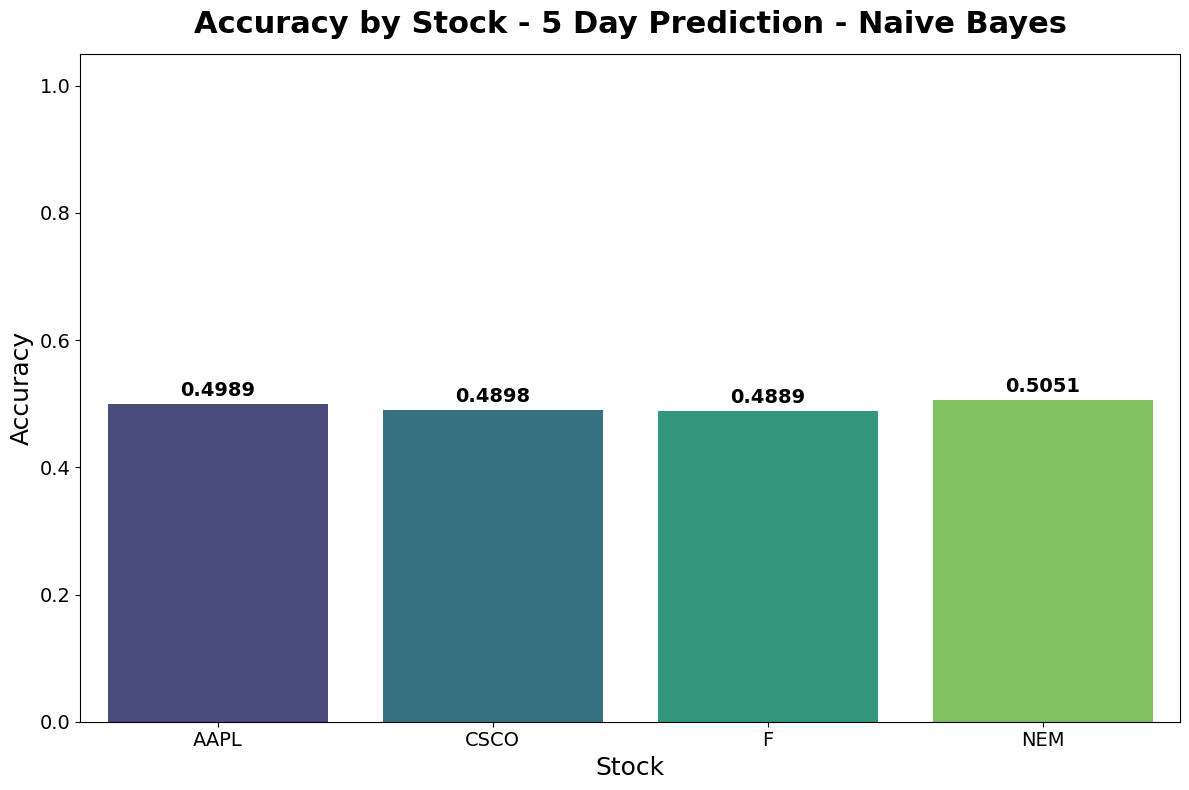

In [4]:
# Visualization 1: Accuracy Comparison
import seaborn as sns
import matplotlib.pyplot as plt

viz_horizon = 5  # Next week

# Prepare data
plot_data = []
for ticker in ANALYSIS_TICKERS:
    m = results_data[ticker][viz_horizon]['metrics']
    plot_data.append({'Ticker': ticker, 'Accuracy': m['Accuracy']})

df_acc = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_acc, x='Ticker', y='Accuracy', palette='viridis')
plt.title('Accuracy by Stock - 5 Day Prediction - Naive Bayes', fontsize=22, fontweight='bold', pad=15)
plt.ylim(0, 1.05)
plt.xlabel('Stock', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\3267535833.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_mcc, x='Ticker', y='MCC', palette='coolwarm')


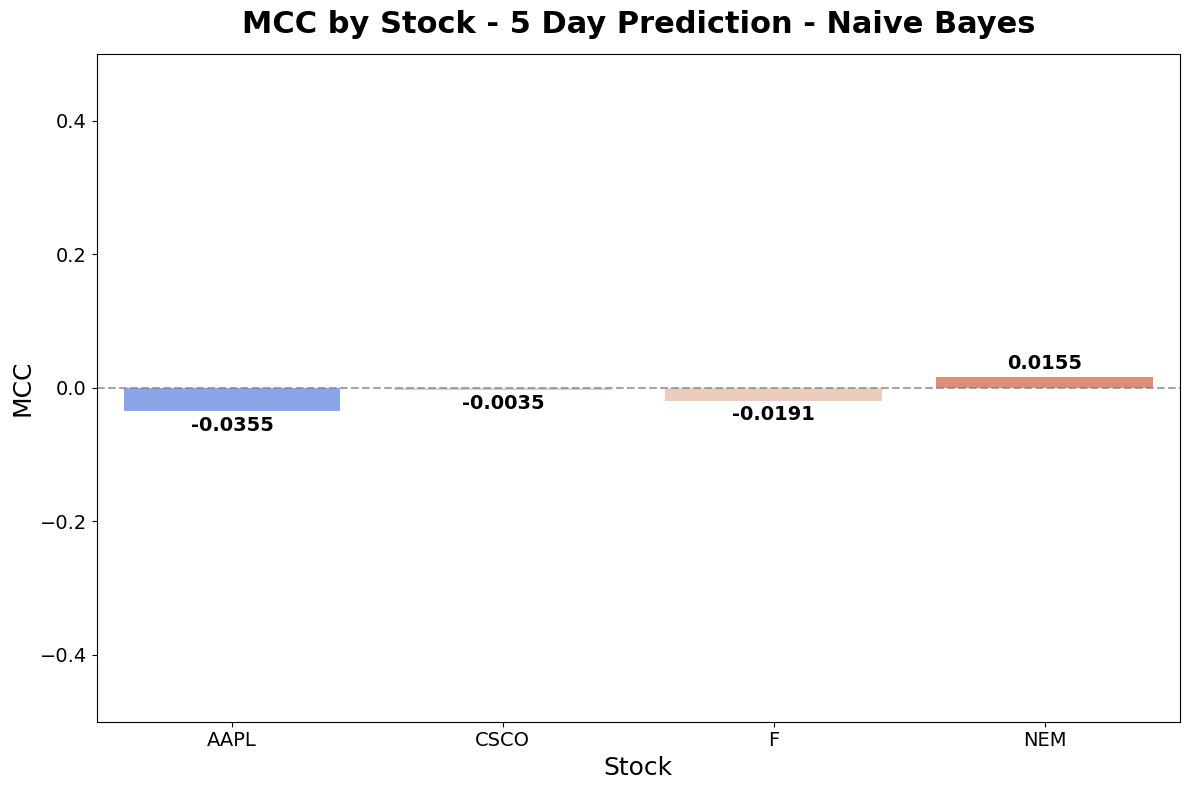

In [5]:
# Visualization 2: MCC (Matthews Correlation Coefficient) Comparison
viz_horizon = 5

plot_data = []
for ticker in ANALYSIS_TICKERS:
    m = results_data[ticker][viz_horizon]['metrics']
    plot_data.append({'Ticker': ticker, 'MCC': m['MCC']})

df_mcc = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_mcc, x='Ticker', y='MCC', palette='coolwarm')
plt.title('MCC by Stock - 5 Day Prediction - Naive Bayes', fontsize=22, fontweight='bold', pad=15)
plt.ylim(-0.5, 0.5)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Stock', fontsize=18)
plt.ylabel('MCC', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\3498161198.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_auc, x='Ticker', y='ROC-AUC', palette='Blues_d')


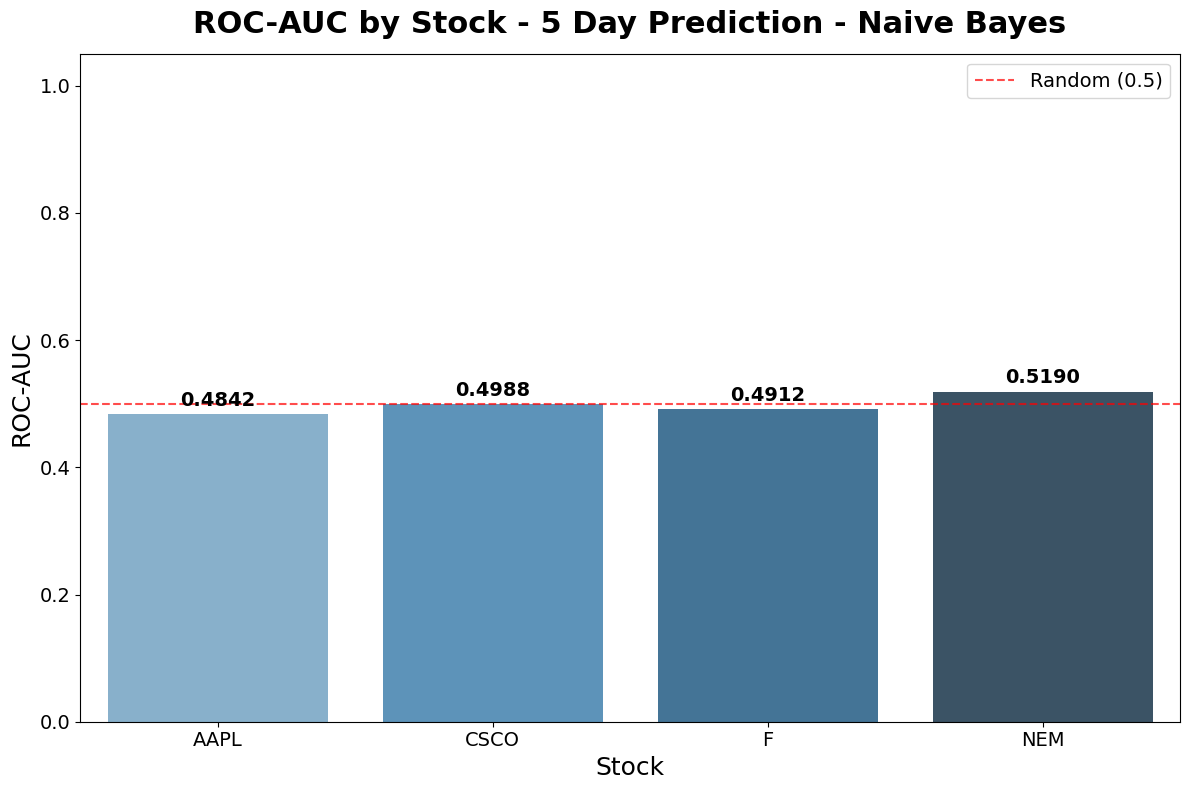

In [6]:
# Visualization 3: ROC-AUC Comparison
viz_horizon = 5

plot_data = []
for ticker in ANALYSIS_TICKERS:
    m = results_data[ticker][viz_horizon]['metrics']
    plot_data.append({'Ticker': ticker, 'ROC-AUC': m['ROC-AUC']})

df_auc = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_auc, x='Ticker', y='ROC-AUC', palette='Blues_d')
plt.title('ROC-AUC by Stock - 5 Day Prediction - Naive Bayes', fontsize=22, fontweight='bold', pad=15)
plt.ylim(0, 1.05)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random (0.5)')
plt.xlabel('Stock', fontsize=18)
plt.ylabel('ROC-AUC', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=14)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\3577089876.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_ll, x='Ticker', y='Log Loss', palette='rocket')


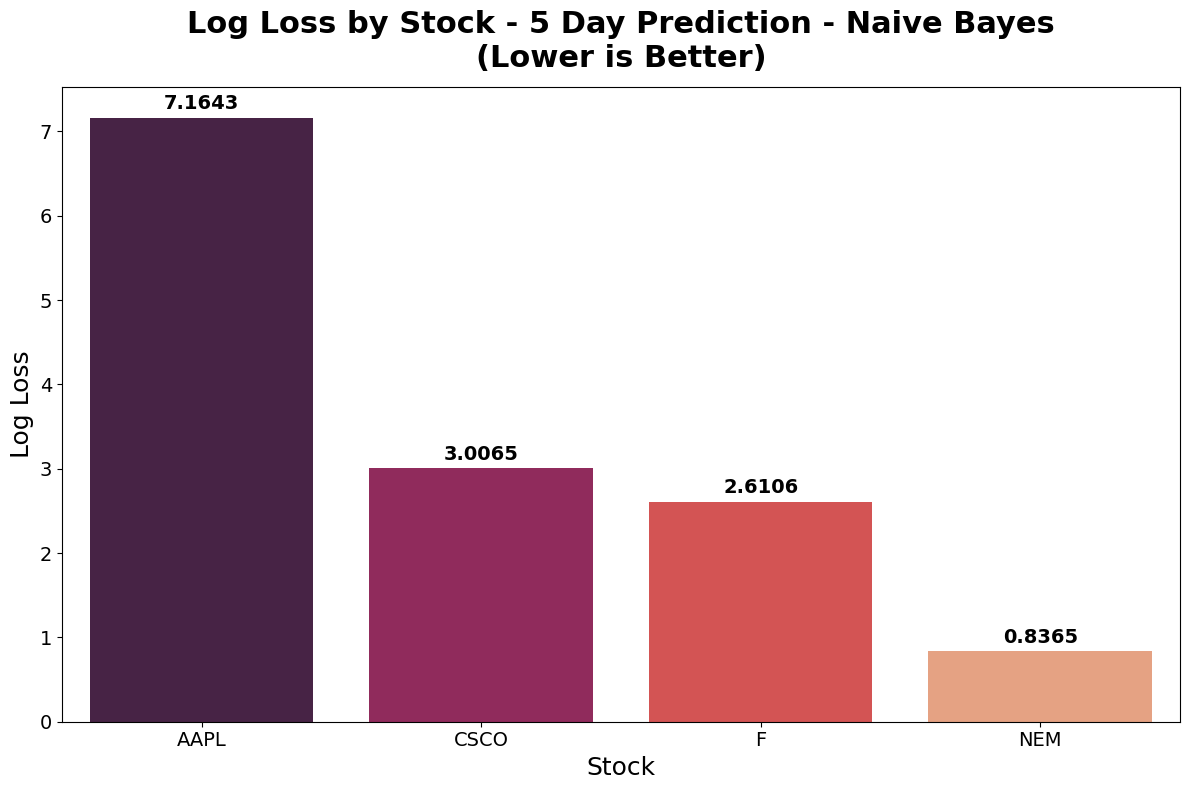

In [7]:
# Visualization 4: Log Loss Comparison
viz_horizon = 5

plot_data = []
for ticker in ANALYSIS_TICKERS:
    m = results_data[ticker][viz_horizon]['metrics']
    plot_data.append({'Ticker': ticker, 'Log Loss': m['Log Loss']})

df_ll = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_ll, x='Ticker', y='Log Loss', palette='rocket')
plt.title('Log Loss by Stock - 5 Day Prediction - Naive Bayes\n(Lower is Better)', fontsize=22, fontweight='bold', pad=15)
plt.xlabel('Stock', fontsize=18)
plt.ylabel('Log Loss', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\3068851122.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_dd, x='Ticker', y='Max Drawdown', palette='flare')


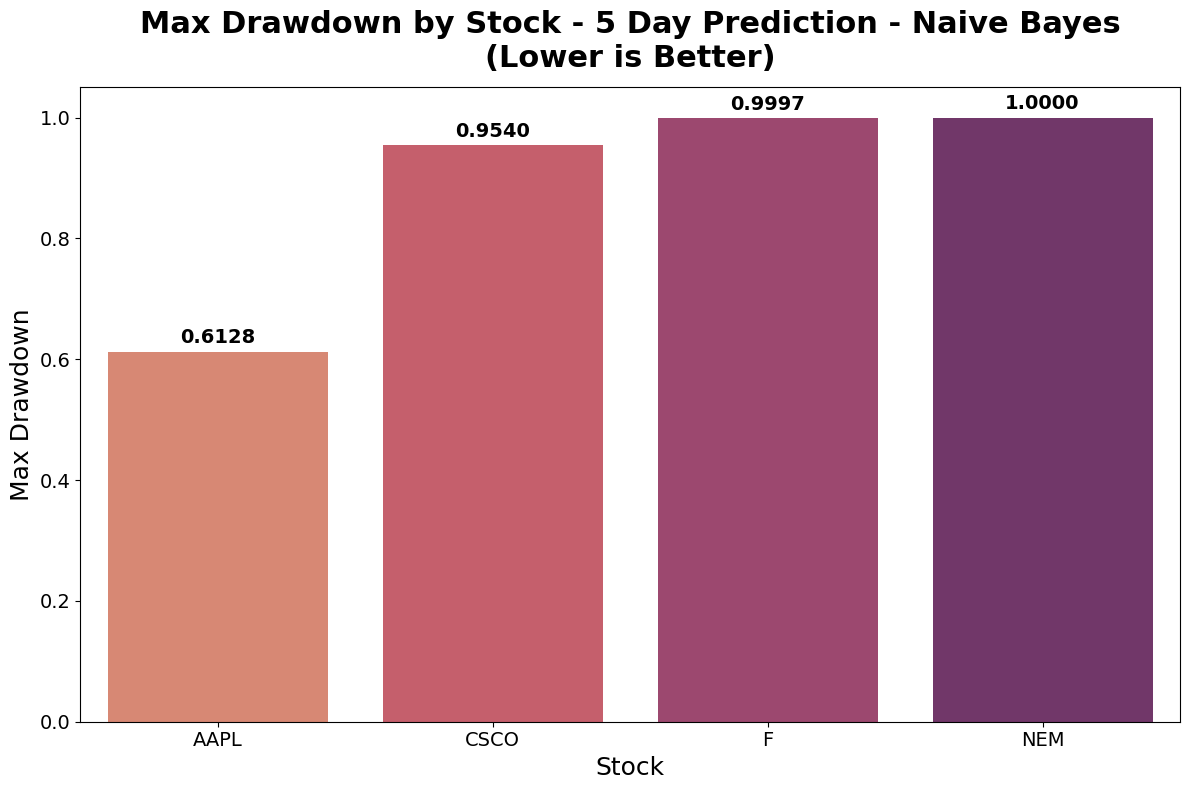

In [8]:
# Visualization 5: Max Drawdown Comparison
viz_horizon = 5

plot_data = []
for ticker in ANALYSIS_TICKERS:
    m = results_data[ticker][viz_horizon]['metrics']
    plot_data.append({'Ticker': ticker, 'Max Drawdown': m['Max Drawdown']})

df_dd = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_dd, x='Ticker', y='Max Drawdown', palette='flare')
plt.title('Max Drawdown by Stock - 5 Day Prediction - Naive Bayes\n(Lower is Better)', fontsize=22, fontweight='bold', pad=15)
plt.xlabel('Stock', fontsize=18)
plt.ylabel('Max Drawdown', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\3890544116.py:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--', color='gray', label='Random (0.5)')
C:\Users\fabri\AppData\Local\Temp\ipykernel_12932\3890544116.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--', color='gray', label='Random (0.5)')


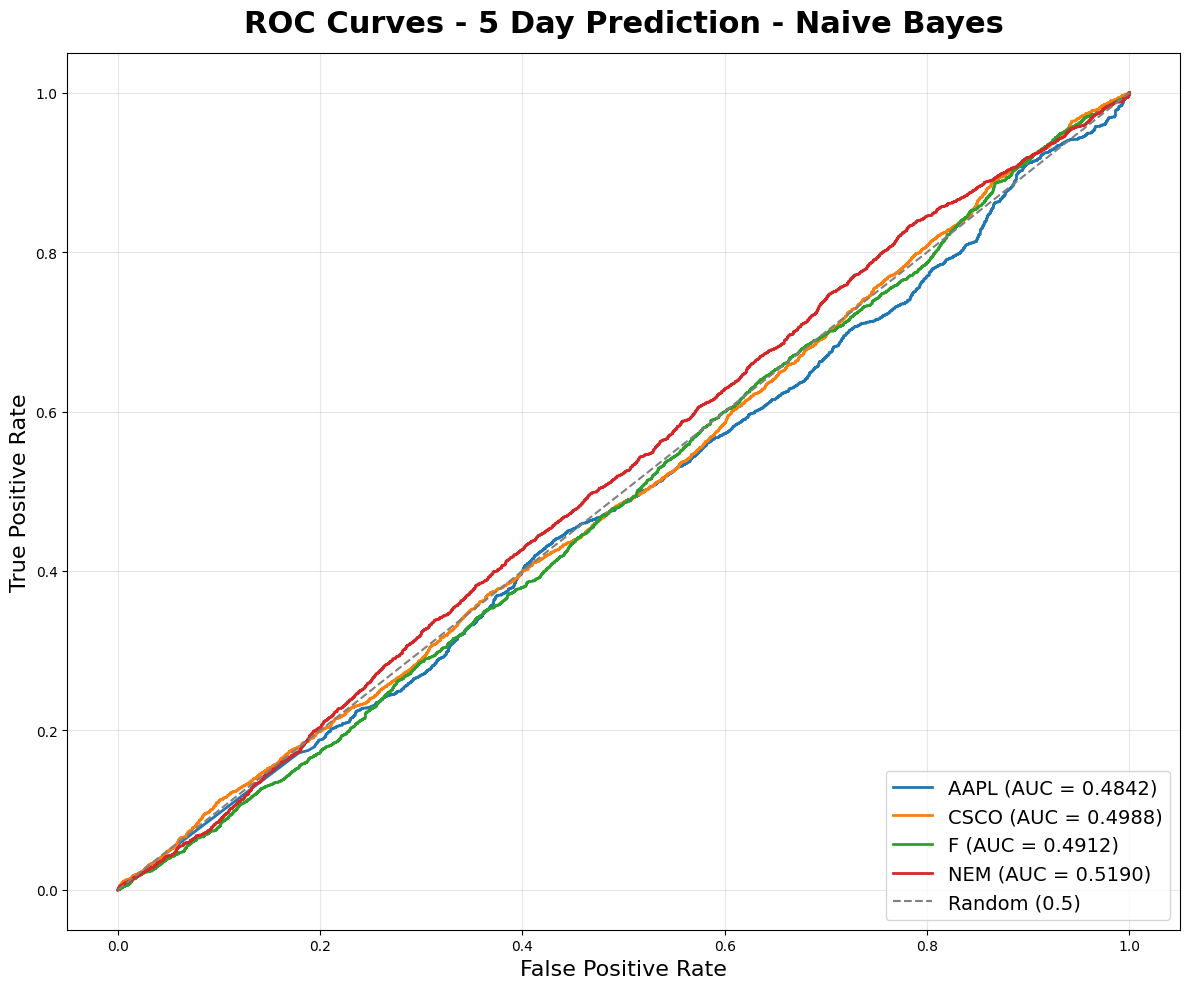

In [9]:
# Visualization 6: ROC Curves
viz_horizon = 5

plt.figure(figsize=(12, 10))
for ticker in ANALYSIS_TICKERS:
    res = results_data[ticker][viz_horizon]
    y_test = res['y_test']
    y_prob = res['y_prob']
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = res['metrics']['ROC-AUC']
    
    plt.plot(fpr, tpr, label=f'{ticker} (AUC = {auc_score:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linestyle='--', color='gray', label='Random (0.5)')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curves - 5 Day Prediction - Naive Bayes', fontsize=22, fontweight='bold', pad=15)
plt.legend(fontsize=14, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Metrics Summary Table
viz_horizon = 5

summary_data = []
for ticker in ANALYSIS_TICKERS:
    m = results_data[ticker][viz_horizon]['metrics']
    row = {
        'Ticker': ticker,
        'Accuracy': m['Accuracy'],
        'MCC': m['MCC'],
        'ROC-AUC': m['ROC-AUC'],
        'Log Loss': m['Log Loss'],
        'Max Drawdown': m['Max Drawdown']
    }
    summary_data.append(row)

metrics_table = pd.DataFrame(summary_data)
metrics_table = metrics_table.set_index('Ticker').reset_index()

print("="*60)
print(f"METRICS SUMMARY - {viz_horizon} DAY (NEXT WEEK) PREDICTION")
print("="*60)
display(metrics_table)

METRICS SUMMARY - 5 DAY (NEXT WEEK) PREDICTION


,Ticker,Accuracy,MCC,ROC-AUC,Log Loss,Max Drawdown
0,AAPL,0.498873,-0.035468,0.484248,7.164275,0.612772
1,CSCO,0.489796,-0.003548,0.498790,3.006513,0.953966
2,F,0.488933,-0.019079,0.491218,2.610583,0.999722
3,NEM,0.505103,0.015509,0.519048,0.836489,0.999972
